In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

# Dataset 

## Cleaning Data

In [2]:
!curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   378k      0 --:--:-- --:--:-- --:--:--  382k


In [3]:
words = [i.strip() for i in open("names.txt").readlines()]
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# MLP Model

## Building a Block

The goal is to create a MLP model which will make a prediction based on the previous 3 characters. Each character will be assigned an embedding and we will in turn use the 3 embeddings generated from these 3 characters to make a prediction

![MLP Schema](MLP_Diagram.png)

These prior 3 characters that we are using to make a prediction will be called the `block_size`

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Experiments with Embeddings

Similar to our weights we can generate embeddings using a torch.randn. In our case, we'll be starting by using an embedding dimension of 2

In [7]:
 C = torch.randn((27,2))

If we want to get the embedding for a number, we take it's index according to our `stoi` dictionary

In [8]:
C[stoi['b']]

tensor([-0.2921,  0.8547])

However, we can also use a one-hot encoded value by performing some more matrix multiplication

In [9]:
ind = stoi['b']
F.one_hot(torch.tensor(ind),num_classes=27).float() @ C

tensor([-0.2921,  0.8547])

We can take advantage of pytorch's support for lists of indexes to get the relevant embeddings for a series of characters

In [10]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

Therefore we can just use `X` which contains the indexes of the individual characters in a given block of characters to generate a list of embeddings that correspond to the characters in the block.

In [11]:
C[X]

tensor([[[ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00]],

        [[ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00],
         [-6.7963e-01, -1.2524e-01]],

        [[ 3.9669e-02,  1.0601e+00],
         [-6.7963e-01, -1.2524e-01],
         [-2.9936e-01,  6.8382e-02]],

        [[-6.7963e-01, -1.2524e-01],
         [-2.9936e-01,  6.8382e-02],
         [-2.9936e-01,  6.8382e-02]],

        [[-2.9936e-01,  6.8382e-02],
         [-2.9936e-01,  6.8382e-02],
         [-1.8553e+00, -9.0283e-01]],

        [[ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00]],

        [[ 3.9669e-02,  1.0601e+00],
         [ 3.9669e-02,  1.0601e+00],
         [-1.0657e+00, -2.1607e+00]],

        [[ 3.9669e-02,  1.0601e+00],
         [-1.0657e+00, -2.1607e+00],
         [-3.9801e-01, -9.2553e-01]],

        [[-1.0657e+00, -2.1607e+00],
         [-3.9801e-01, -9.2553e-01],
         [-4.0844e-01,

## Combining Our Embeddings

Note that our Embeddings give us a 3 x 2 matrix. We'd ideally like to have a single vector with 6 elements. Therefore, we can use some inbuilt torch functions to get what we want

In [12]:
emb = C[X][0]
emb

tensor([[0.0397, 1.0601],
        [0.0397, 1.0601],
        [0.0397, 1.0601]])

Ideally, what we want is

In [13]:
torch.tensor([1.9348,0.0306,1.9348, 0.0306,1.9348, 0.0306])

tensor([1.9348, 0.0306, 1.9348, 0.0306, 1.9348, 0.0306])

Karpathy goes through three different ways to do so

1. Using the `.cat` functionality - However, this cannot be generalised and we cannot easily change the dimensionality of our embeddings.
2. Using the `.unbind` function - however, this is inefficient since we are creating a new variable in memory
3. using the `.view` function - This does not create a new variable in memory but instead simply works off the original `.storage` variable

Hint: #3 is the best and most efficient one to use

In [14]:
emb = C[X]

In [15]:
cat_torch = torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)

In [16]:
unbind_cat_torch = torch.cat(torch.unbind(emb,1),1)

We can validate that this is true by performing an element wise comparison

In [17]:
cat_torch == unbind_cat_torch

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [18]:
emb.view(32,6) == unbind_cat_torch

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

## Two Layer Perceptron

We now create a set of weights and our two layers which will create a final output vector of 27 elements

In [19]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [20]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [21]:
h

tensor([[-0.9901,  0.9739,  0.9627,  ...,  0.9997, -0.6647, -0.0996],
        [-0.9999,  0.8891, -0.9399,  ...,  0.9957,  0.5909,  0.0978],
        [-0.9989,  0.1173, -0.1139,  ...,  0.9577,  0.5397, -0.8893],
        ...,
        [-0.9356, -0.4122,  0.9999,  ..., -0.9999,  0.6793, -0.8318],
        [-0.9895,  0.8568,  0.9996,  ..., -0.7100, -0.3347, -0.2608],
        [-1.0000,  0.5301, -0.9997,  ...,  0.5021,  0.9272,  0.0993]])

In [22]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2

In [24]:
counts = logits.exp()
prob = counts / counts.sum(1,keepdims=True)

In [25]:
prob.shape

torch.Size([32, 27])

# Training Our Neural Network

## Loss Function

We've now generated a total of 32 predictions for each of our individual x values. our next step is to then calculate the loss using the *average negative log likelihood*

In [26]:
# First get the relevant probabilities
loss = prob[torch.arange(32),Y]

# Then get the negative log of the probabilities
loss = -1 * loss.log()

# Then take the mean of the value
loss = loss.mean()

print(loss)

tensor(15.4219)


It turns out that our loss function has a name, the cross-entropy. In our case, we definitely want to use the pytorch implementation. 

This is because 

1. We want to make sure we are using an optimized version of our loss function
2. We want to avoid any unfortunate mathematical issues

We can validate that we get the same result when we use the `cross_entropy` function with our original `logits` and `Y`

In [27]:
F.cross_entropy(logits,Y)

tensor(15.4219)

Turns out that we can get unexplained behaviour when working with exponentiated values. 

In [28]:
logits = torch.tensor([-44,-3,100,200])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., nan, nan])

In [29]:
logits = torch.tensor([-44,-3,100,200]) - 200
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 0.0000e+00, 3.7835e-44, 1.0000e+00])

## Training our network

Let's now put together what we've come up with into a single value

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters)

3481

In [32]:
for p in parameters:
  p.requires_grad = True

We can now try to run our model for a few iterations

In [33]:
for _ in range(10):
    emb = C[X]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y)
    loss.backward()

    print(f"Average Loss : {loss}")

    for p in parameters:
        p.data += -0.1 * p.grad
    

Average Loss : 17.76971435546875
Average Loss : 13.656400680541992
Average Loss : 11.298768997192383
Average Loss : 9.4524564743042
Average Loss : 7.984262943267822
Average Loss : 6.891321182250977
Average Loss : 6.100014686584473
Average Loss : 5.452036380767822
Average Loss : 4.898151874542236
Average Loss : 4.4146647453308105


We can run this for more iterations to get the loss to decrease more on our 32 examples. However, there is a strong chance that we are overfitting on our dataset - since we are working with only 32 examples and have 1100+ parameters

## Extending to the entire dataset

Now we try to expand our training to the entire dataset instead of just 32 characters

In [34]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)
print(f"Num Examples : {len(X)}")

Num Examples : 228146


In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [36]:
for p in parameters:
  p.requires_grad = True

In [37]:
for _ in range(10):
    emb = C[X]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y)
    loss.backward()

    print(f"Average Loss : {loss}")

    for p in parameters:
        p.data += -0.1 * p.grad
    

Average Loss : 19.505229949951172
Average Loss : 17.084484100341797
Average Loss : 15.776531219482422
Average Loss : 14.833340644836426
Average Loss : 14.002605438232422
Average Loss : 13.253263473510742
Average Loss : 12.57991886138916
Average Loss : 11.983102798461914
Average Loss : 11.470492362976074
Average Loss : 11.05185604095459


## Mini Batch

Since we're doing a lot of work doing a backward and forward pass on 28000+ input examples, We can perform our normalization using a randomly selected group of inputs, often called a mini batch

In [38]:
X.shape

torch.Size([228146, 3])

In [39]:
print(torch.randint(0,5,(3,)))
print(torch.randint(0,X.shape[0],(3,)))

tensor([3, 2, 0])
tensor([138286,  22290, 188127])


We can use this randomly generated set of integers in order to generate a list of 32 randomly selected integers that correspond to a valid input in our dataset

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [41]:
%%time
for _ in range(10):
    ix = torch.randint(0,X.shape[0],(32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y[ix])
    loss.backward()

    print(f"Average Loss : {loss}")

    for p in parameters:
        p.data += -0.1 * p.grad
    

Average Loss : 23.03775405883789
Average Loss : 14.046167373657227
Average Loss : 16.10528564453125
Average Loss : 14.860451698303223
Average Loss : 15.716188430786133
Average Loss : 11.141573905944824
Average Loss : 10.73473072052002
Average Loss : 14.11490249633789
Average Loss : 11.50970458984375
Average Loss : 15.008676528930664
CPU times: user 35 ms, sys: 7.97 ms, total: 42.9 ms
Wall time: 11 ms


In [42]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [43]:
%%time
for _ in range(10):
    emb = C[X]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y)
    loss.backward()

    print(f"Average Loss : {loss}")

    for p in parameters:
        p.data += -0.1 * p.grad

Average Loss : 19.505229949951172
Average Loss : 17.08448600769043
Average Loss : 15.776532173156738
Average Loss : 14.833341598510742
Average Loss : 14.002608299255371
Average Loss : 13.253263473510742
Average Loss : 12.57991886138916
Average Loss : 11.983104705810547
Average Loss : 11.47049331665039
Average Loss : 11.05185604095459
CPU times: user 6.23 s, sys: 292 ms, total: 6.52 s
Wall time: 1.78 s


In [44]:
(6.95 * 1000) / 32

217.1875

By using a mini batch, we were able to speed up the training of our neural network and still arrive at a comparable loss. 

In our example above, we saw an apprximate 200x speedup using the mini-batch approach. This means that for the same amount of time, we can run a significantly larger amount of steps

In [45]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [46]:
%%time
epochs = 6000
for idx in range(epochs):
    ix = torch.randint(0,X.shape[0],(32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y[ix])
    loss.backward()

    if idx % 1000 == 0:
        print(f"{idx}/{epochs} : Average Loss : {loss}")

    for p in parameters:
        p.data += -0.1 * p.grad
    

0/6000 : Average Loss : 21.071876525878906
1000/6000 : Average Loss : 2.530060291290283
2000/6000 : Average Loss : 2.7828454971313477
3000/6000 : Average Loss : 2.675440549850464
4000/6000 : Average Loss : 2.6496787071228027
5000/6000 : Average Loss : 2.465813398361206
CPU times: user 6.55 s, sys: 111 ms, total: 6.66 s
Wall time: 1.71 s


We can see that in the approximate amount of time, we were able to run almost 3000 more training steps as compared to using the entire dataset.


In [47]:
emb = C[X]
h = torch.tanh(emb.view(-1,6)@W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
print(loss)

tensor(2.5721, grad_fn=<NllLossBackward0>)


We were also able to achieve a significantly lower loss of 2.5299 as compared to 11.05185604095459 when evaluated against the entire training set

# Hyper-Parameter Tuning

## Learning Rate Optimization

We experiment with a quick attempt at learning rate optimization

In [48]:
def generate_loss_for_lr(lr=0.1):
    print(f"---Calculating Loss for Learning Rate of {lr}")
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    
    for p in parameters:
      p.requires_grad = True

    epochs = 200

    idx_and_loss = []
    for idx in range(epochs):
        ix = torch.randint(0,X.shape[0],(32,))
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1,6)@W1+b1)
        logits = h @ W2 + b2
    
        for p in parameters:
            p.grad = None
        
        loss = F.cross_entropy(logits,Y[ix])
        idx_and_loss.append([idx,loss])
        loss.backward()
        
    
        if idx % 50 == 0:
            print(f"{idx}/{epochs} : Average Loss : {loss}")
    
        for p in parameters:
            p.data += -lr * p.grad

    return idx_and_loss

We can see that when we modify the learning rate, the loss changes at a very different amount. In fact, if we choose the wrong learning rate, we end up with an unstable learning rate.

In [49]:
loss_0_1 = generate_loss_for_lr()
loss_1 = generate_loss_for_lr(1)
loss_10 = generate_loss_for_lr(10)
loss_50 = generate_loss_for_lr(50)

---Calculating Loss for Learning Rate of 0.1
0/200 : Average Loss : 20.99297332763672
50/200 : Average Loss : 6.564327716827393
100/200 : Average Loss : 4.2535905838012695
150/200 : Average Loss : 3.2690165042877197
---Calculating Loss for Learning Rate of 1
0/200 : Average Loss : 17.47030258178711
50/200 : Average Loss : 6.547647476196289
100/200 : Average Loss : 8.522148132324219
150/200 : Average Loss : 6.128942012786865
---Calculating Loss for Learning Rate of 10
0/200 : Average Loss : 20.594493865966797
50/200 : Average Loss : 100.12458801269531
100/200 : Average Loss : 64.8740463256836
150/200 : Average Loss : 77.93840026855469
---Calculating Loss for Learning Rate of 50
0/200 : Average Loss : 19.939647674560547
50/200 : Average Loss : 415.4334716796875
100/200 : Average Loss : 264.834228515625
150/200 : Average Loss : 433.4309387207031


We can do a bit more of a methodological method - using `torch.linspace` to generate exponentially spaced learning rates

In [50]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [51]:
lre

tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880, -2.9850, -2.9820, -2.9790,
        -2.9760, -2.9730, -2.9700, -2.9670, -2.9640, -2.9610, -2.9580, -2.9550,
        -2.9520, -2.9489, -2.9459, -2.9429, -2.9399, -2.9369, -2.9339, -2.9309,
        -2.9279, -2.9249, -2.9219, -2.9189, -2.9159, -2.9129, -2.9099, -2.9069,
        -2.9039, -2.9009, -2.8979, -2.8949, -2.8919, -2.8889, -2.8859, -2.8829,
        -2.8799, -2.8769, -2.8739, -2.8709, -2.8679, -2.8649, -2.8619, -2.8589,
        -2.8559, -2.8529, -2.8498, -2.8468, -2.8438, -2.8408, -2.8378, -2.8348,
        -2.8318, -2.8288, -2.8258, -2.8228, -2.8198, -2.8168, -2.8138, -2.8108,
        -2.8078, -2.8048, -2.8018, -2.7988, -2.7958, -2.7928, -2.7898, -2.7868,
        -2.7838, -2.7808, -2.7778, -2.7748, -2.7718, -2.7688, -2.7658, -2.7628,
        -2.7598, -2.7568, -2.7538, -2.7508, -2.7477, -2.7447, -2.7417, -2.7387,
        -2.7357, -2.7327, -2.7297, -2.7267, -2.7237, -2.7207, -2.7177, -2.7147,
        -2.7117, -2.7087, -2.7057, -2.70

Let's see how this might work in practice

In [52]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [53]:
lri = []
lossi = []

for idx in range(1000):
    ix = torch.randint(0,X.shape[0],(32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y[ix])
    loss.backward()

    lr = lrs[idx]
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    

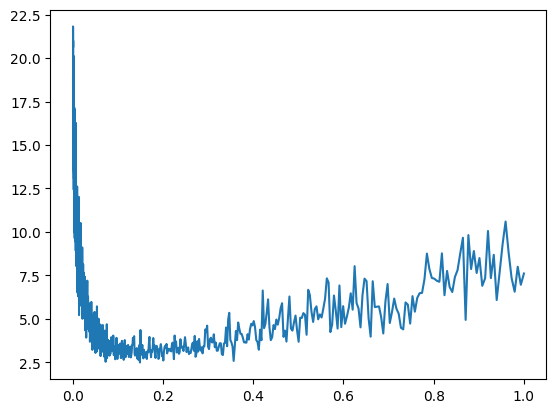

In [54]:
plt.plot(lri,lossi)

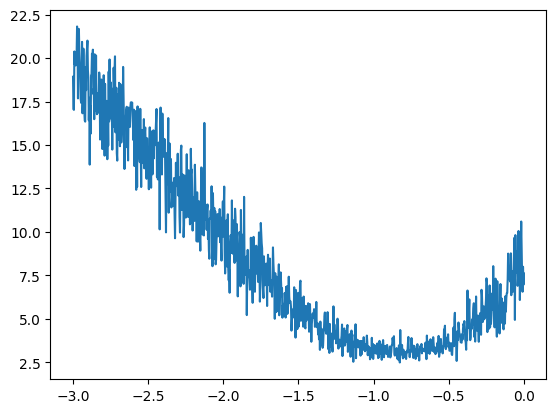

In [55]:
plt.plot(lre,lossi)

Seems like our learning rate is best around $10^{-1}$ which was our initial learning rate.

## Learning Rate Decay

We can use our optimized learning rate and then start using a significantly lower learning rate after you've trained using this optimized learning rate for a while.

In this case, we can implement it by simply reducing our learning rate by a factor of 10 every 10000 steps

In [58]:
import math

In [63]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

lri = []
lossi = []

epochs = 80000
introduce_decay = 0.5

for idx in range(epochs):
    ix = torch.randint(0,X.shape[0],(32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Y[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    

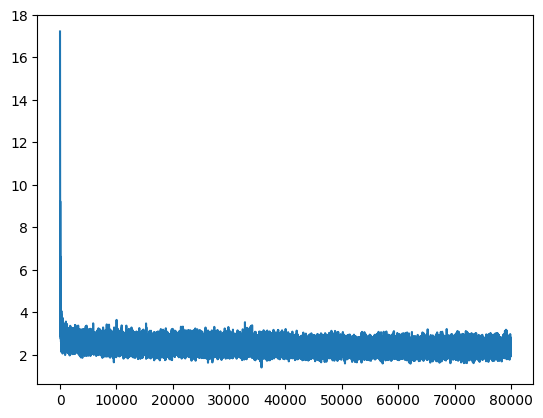

In [64]:
plt.plot([i for i in range(epochs)],lossi)

In [65]:
loss.item()

2.1371371746063232

## Test, Train, Validation

Often times, as we train our model, we risk overfitting onto the training data set. This happens because with enough epochs, our model will start to memorize the data that it has been given.

As a result, we normally divide our datasets into a test-train set so that we do not overfit onto the training data. Ideally we test sparingly on our test dataset so we don't risk training on the test dataset.

Let's first create our train, test , validation split

In [67]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [80]:
lri = []
lossi = []

epochs = 80000
introduce_decay = 0.5

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    

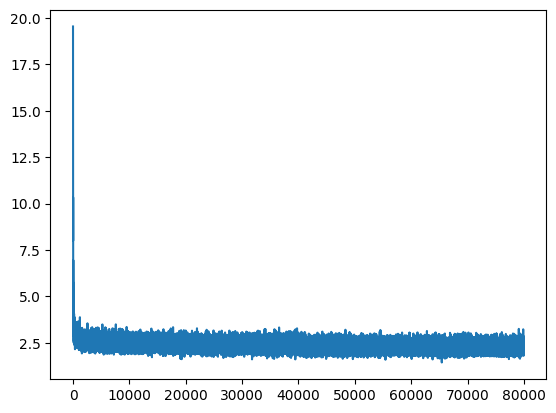

In [81]:
plt.plot([i for i in range(epochs)], lossi)


We can validate that our model is not overfitting on the training dataset by comparing the loss on the training dataset and the validation dataset.

In [83]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2969, grad_fn=<NllLossBackward0>)

In [84]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2990, grad_fn=<NllLossBackward0>)

# Model Architecture Changes

## Changing Hidden Layer Size

Our model has only 11897 parameters and hence it will not be powerful enough to deal with the machine learning problem. Hence, we increase the size of the hidden layer so that it can do more.

In [85]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [86]:
lri = []
lossi = []

epochs = 80000
introduce_decay = 0.5

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    

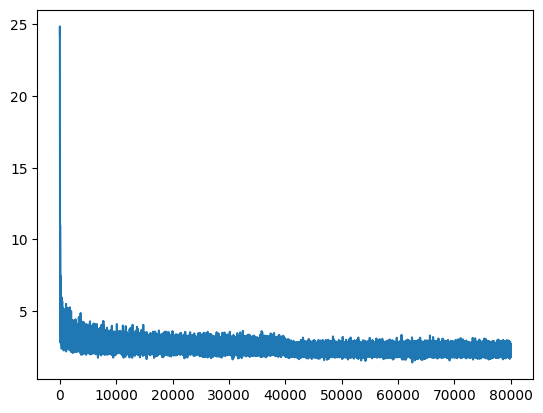

In [87]:
plt.plot([i for i in range(epochs)], lossi)

In [88]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2892, grad_fn=<NllLossBackward0>)

In [89]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2907, grad_fn=<NllLossBackward0>)

It turns out the neural net has comparable performance even with the increased hidden layer size. We might be able to get a better result if we train more. So let's run it a few more iterations

In [90]:
epochs = 30000
introduce_decay = 0.8

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())

In [91]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2583, grad_fn=<NllLossBackward0>)

In [92]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2657, grad_fn=<NllLossBackward0>)

## Embedding Size Changes

We now increase the embedding dimensionality so that we can see if that gets a better result. Let's first see what our model has learnt about the characters

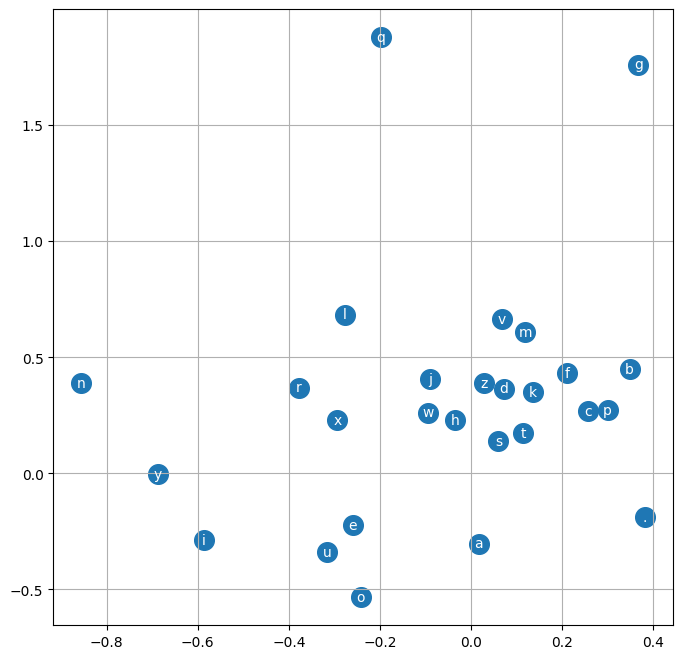

In [93]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

It seems like the model has learnt that the vowels - a,e,i,o and u are quite similar to one another and are more intercharngable versus say r. Let's now try using our earlier model with a larger hidden layer and a larger embedding size

In [106]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [107]:
lri = []
lossi = []
log_lossi = []
epochs = 100000
introduce_decay = 0.8

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

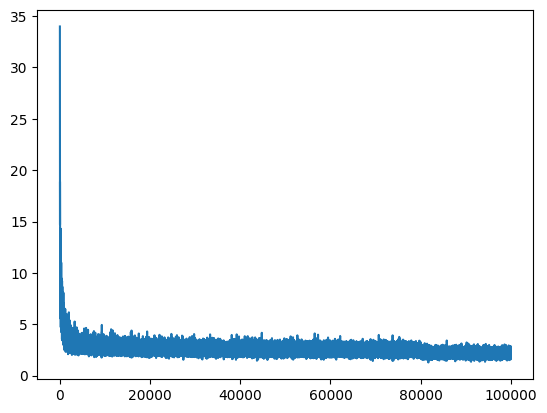

In [108]:
plt.plot([i for i in range(epochs)], lossi)

You'll notice that when we plot the loss, we tend to have a hockey stick like appearance. This isn't ideal, so let's try to plot our log loss instead

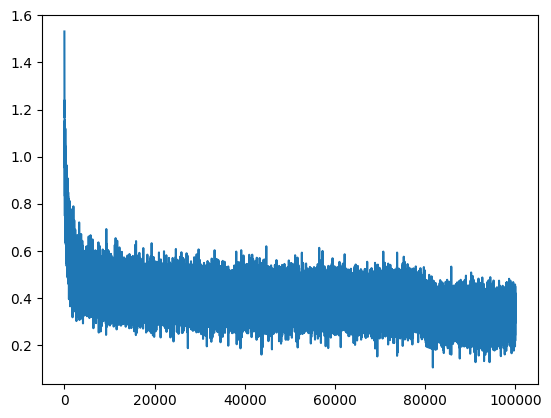

In [109]:
plt.plot([i for i in range(epochs)], log_lossi)

In [104]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0890, grad_fn=<NllLossBackward0>)

In [105]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1691, grad_fn=<NllLossBackward0>)

# Generating Samples

Here's a quick snippet from Andrej to generate sample outputs

In [110]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mohailyna.
zeellend.
rylla.
emmadieja.
leg.
adered.
elin.
shi.
jen.
eden.
sananaraelynn.
hona.
cayshaberging.
jest.
jairetlynn.
nophianu.
zen.
dariyah.
faeha.
kayjahston.
